In [98]:
import numpy as np
import os
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import time

In [187]:
train_path = 'lstm/data/ptb.train.txt'
valid_path = 'lstm/data/ptb.valid.txt'
test_path = 'lstm/data/ptb.test.txt'

# Load data
def load_data(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        data = []
        for line in lines:
            data.append(line.strip())
        return data

train_data = load_data(train_path)
valid_data = load_data(valid_path)
test_data = load_data(test_path)

In [188]:
print('Number of training tokens:', len(train_data))
print('Number of validation tokens:', len(valid_data))
print('Number of test tokens:', len(test_data))

for i in range(5):
    random_index = np.random.randint(0, len(train_data))
    print('Sample:', train_data[random_index])
    
print('First 10 training tokens:', train_data[:10])

Number of training tokens: 42068
Number of validation tokens: 3370
Number of test tokens: 3761
Sample: israel has been accused in the past of using <unk> to seek elements needed to develop nuclear weapons
Sample: there can be no question of us <unk> abandoning the armed struggle he said
Sample: at its november meeting it will try to revise its quotas to satisfy persian gulf members that can produce far more oil than their <unk>
Sample: fear is the father of panic
Sample: last month american home products said it was <unk> production and distribution of all N of quantum 's generic drug products pending the completion of an <unk> internal audit
First 10 training tokens: ['aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter', 'pierre <unk> N years old will join the board as a nonexecutive director nov. N', 'mr. <unk> is chairman of <unk> n.v. the dutch publishing grou

In [189]:
#1.3
def add_eos(data):
    return [line + ' <eos>' for line in data]

train_data = add_eos(train_data)
valid_data = add_eos(valid_data)
test_data = add_eos(test_data)

print('First 10 training tokens:', train_data[:10])

First 10 training tokens: ['aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos>', 'pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos>', 'mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos>', 'rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate <eos>', 'a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported <eos>', 'the asbestos fiber <unk> is unusually <unk> once it enters the <unk> with even brief exposures to it causing symptoms that show up decades later researchers said <eos>', '<unk> inc. the unit of new york-based <unk> corp. that makes kent cigarettes stopped using <unk> in

In [190]:
#1.4
def calculate_words_number(data):
    return len(' '.join(data).split(' '))

print('Number of training words:', calculate_words_number(train_data))
print('Number of validation words:', calculate_words_number(valid_data))
print('Number of test words:', calculate_words_number(test_data))

Number of training words: 929589
Number of validation words: 73760
Number of test words: 82430


In [192]:
total_number = calculate_words_number(train_data) + calculate_words_number(valid_data) + calculate_words_number(test_data)
print('Total number of words:', total_number)

Total number of words: 1085779


In [193]:
#1.5
def freq_dict(data):
    words = ' '.join(data).split(' ')
    unique, counts = np.unique(words, return_counts=True)
    return dict(zip(unique, counts))

dict_all = freq_dict(train_data+valid_data+test_data)
print('Number of unique words:', len(dict_all))


Number of unique words: 10000


In [194]:
train_data = ' '.join(train_data).split(' ')
valid_data = ' '.join(valid_data).split(' ')
test_data = ' '.join(test_data).split(' ')

In [196]:
print('Number of unique words in train:', len(freq_dict(train_data)))
print('Number of unique words in valid:', len(freq_dict(valid_data)))
print('Number of unique words in test:', len(freq_dict(test_data)))


Number of unique words in train: 10000
Number of unique words in valid: 6022
Number of unique words in test: 6049


In [106]:

# Build vocabulary
def build_vocab(data):
    vocab = {}
    for word in data:
        if word not in vocab:
            vocab[word] = len(vocab)
    return vocab

# Convert data to indices
def convert_to_indices(data, vocab):
    return [vocab[word] for word in data]

# Create batches
def create_batches(data, batch_size, seq_len):
    num_batches = len(data) // batch_size
    data = data[:num_batches * batch_size]
    data = np.array(data)

    return data.reshape(batch_size, -1)


In [107]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
data_all = train_data + valid_data + test_data
vocab = build_vocab(data_all)

# Convert data to indices
train_data = convert_to_indices(train_data, vocab)
valid_data = convert_to_indices(valid_data, vocab)
test_data = convert_to_indices(test_data, vocab)

# Create batches
batch_size = 20
seq_len = 30
train_data = create_batches(train_data, batch_size, seq_len)
valid_data = create_batches(valid_data, batch_size, seq_len)
test_data = create_batches(test_data, batch_size, seq_len)

In [108]:
class ELMAN_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super(ELMAN_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        x = self.embeddings(x)
        out, hidden = self.rnn(x, hidden)
        out = self.linear(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    
    
def train(model, model_type, train_data, valid_data, vocab_size, seq_len, batch_size, num_epochs, learning_rate, device, clip=0):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    valid_losses = []
    train_perplexities = []
    valid_perplexities = []

    num_batches = len(train_data[0]) // seq_len
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = 0
        hidden = model.init_hidden(batch_size)
        for i in range(0, len(train_data[0,:]) - seq_len, seq_len):
            inputs = torch.from_numpy(train_data[:,i:i+seq_len]).to(device)
            targets = torch.from_numpy(train_data[:,(i+1):(i+1)+seq_len]).to(device)

            if model_type == 'LSTM':
                hidden = [h.data.to(device) for h in hidden]
            else:
                hidden = hidden.data.to(device)

            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))

            model.zero_grad()
            loss.backward()
            if clip != 0:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            
            train_loss += loss.item() * batch_size
            
            step = (i+1) // seq_len
            if step % 100 == 0:
                print ('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                        .format(epoch+1, num_epochs, step, num_batches, loss.item(), np.exp(loss.item())))
                
        train_loss /= train_data.size // seq_len
        train_losses.append(train_loss)
        train_perplexities.append(np.exp(train_loss))
        
        valid_loss = 0
        hidden = model.init_hidden(batch_size)
        with torch.no_grad():
            for i in range(0, len(valid_data[0,:]) - seq_len, seq_len):
                inputs = torch.from_numpy(valid_data[:,i:i+seq_len]).to(device)
                targets = torch.from_numpy(valid_data[:,(i+1):(i+1)+seq_len]).to(device)

                if model_type == 'LSTM':
                    hidden = [h.data.to(device) for h in hidden]
                else:
                    hidden = hidden.data.to(device)
                    
                outputs, hidden = model(inputs, hidden)
                loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
                valid_loss += loss.item() * batch_size
                
        valid_loss /= valid_data.size // seq_len
        valid_losses.append(valid_loss)
        valid_perplexities.append(np.exp(valid_loss))

        end_time = time.time()
        print('Epoch:', '%04d' % (epoch + 1), 'train_loss =', '{:.4f}'.format(train_loss),
                'valid_loss =', '{:.4f}'.format(valid_loss),
                'time =', '{:.4f}'.format(end_time - start_time))
        
    return train_losses, valid_losses, train_perplexities, valid_perplexities



In [109]:
# train elman rnn

vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0
num_epochs = 20
learning_rate = 0.0001
model = ELMAN_RNN(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)

train_losses, valid_losses, train_perplexities, valid_perplexities = train(model=model,
                                                                            model_type='ELMANRNN',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device
                                                                            )



Epoch [1/20], Step[0/1549], Loss: 9.2302, Perplexity: 10200.92
Epoch [1/20], Step[100/1549], Loss: 6.4342, Perplexity: 622.78
Epoch [1/20], Step[200/1549], Loss: 6.4705, Perplexity: 645.79
Epoch [1/20], Step[300/1549], Loss: 6.5035, Perplexity: 667.45
Epoch [1/20], Step[400/1549], Loss: 6.2903, Perplexity: 539.31
Epoch [1/20], Step[500/1549], Loss: 6.0118, Perplexity: 408.20
Epoch [1/20], Step[600/1549], Loss: 5.9684, Perplexity: 390.89
Epoch [1/20], Step[700/1549], Loss: 6.2395, Perplexity: 512.61
Epoch [1/20], Step[800/1549], Loss: 5.9496, Perplexity: 383.61
Epoch [1/20], Step[900/1549], Loss: 5.9857, Perplexity: 397.72
Epoch [1/20], Step[1000/1549], Loss: 5.9762, Perplexity: 393.96
Epoch [1/20], Step[1100/1549], Loss: 6.1161, Perplexity: 453.09
Epoch [1/20], Step[1200/1549], Loss: 5.9261, Perplexity: 374.68
Epoch [1/20], Step[1300/1549], Loss: 5.9628, Perplexity: 388.71
Epoch [1/20], Step[1400/1549], Loss: 5.7556, Perplexity: 315.97
Epoch [1/20], Step[1500/1549], Loss: 5.9768, Perpl

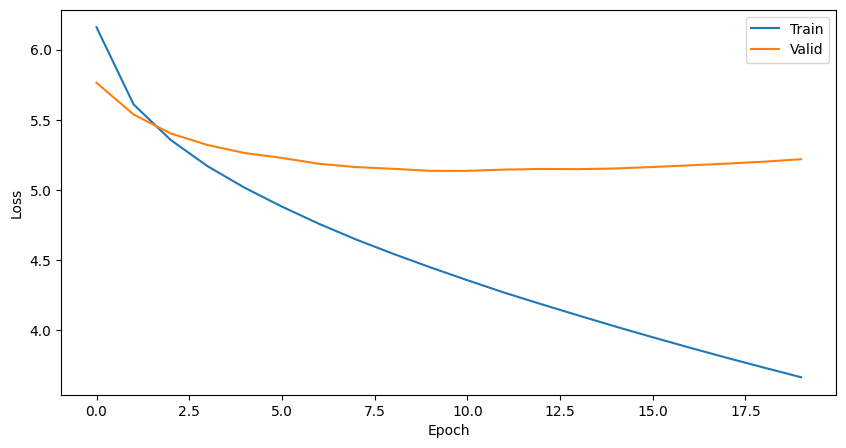

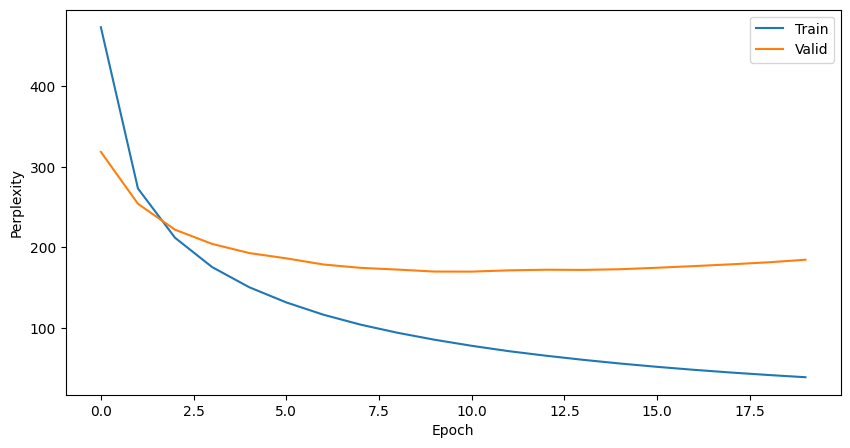

In [110]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot perplexities
plt.figure(figsize=(10, 5))
plt.plot(train_perplexities, label='Train')
plt.plot(valid_perplexities, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

In [134]:

# evaluate
def evaluate(model, model_type, test_data, vocab_size, batch_size, seq_len, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    test_perplexity = 0
    hidden = model.init_hidden(batch_size)
    with torch.no_grad():
        for i in range(0, len(test_data[0]) - seq_len, seq_len):
            inputs = torch.from_numpy(train_data[:,i:i+seq_len]).to(device)
            targets = torch.from_numpy(train_data[:,(i+1):(i+1)+seq_len]).to(device)

            if model_type == 'LSTM':
                hidden = [h.data.to(device) for h in hidden]
            else:
                hidden = hidden.data.to(device)

            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            test_loss += loss.item() * batch_size
            
    test_loss /= test_data.size // seq_len
    test_perplexity = np.exp(test_loss)
    return test_loss, test_perplexity

# Generate text
def generate(model, model_type, statergy, vocab_size, int_to_word, seq_len, device):

    model.eval()    
    words = []
    num_samples = 100
    with torch.no_grad():
        # Set intial hidden ane cell states
        hidden = model.init_hidden(1)
        if model_type == 'LSTM':
            hidden = [h.data.to(device) for h in hidden]
        else:
            hidden = hidden.data.to(device)

        # Select one word id randomly
        prob = torch.ones(vocab_size)
        input = torch.multinomial(prob, num_samples=1).unsqueeze(1).to(device)

        for i in range(num_samples):
            # Forward propagate RNN 
            output, hidden = model(input, hidden)
            prob = output.exp().view(-1)
            if statergy == 'gready':
                # gready
                word_id = output.argmax(dim=2).item()
            elif statergy == 'sampling':
                # sampling
                word_id = torch.multinomial(prob, num_samples=1).item()
            elif statergy == 'beam_search':
                # beam search
                pass

            # Fill input with sampled word id for the next time step
            input.fill_(word_id)

            # File write
            word = int_to_word[word_id]
            if word == '<eos>':
                word = '\n'
                words.append(word)
                print(' '.join(words))
                words = []
            else:
                words.append(word)
        
        return ' '.join(words)



In [112]:
# Test
test_loss, test_perplexity = evaluate(model, "ELMANRNN", test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss), 'test_perplexity =', '{:.4f}'.format(test_perplexity))

# Generate
int_to_word = dict((v, k) for k, v in vocab.items())
generated_words = generate(model, "ELMANRNN", "sampling", vocab_size, int_to_word, seq_len, device)
print(generated_words)

# Save model
#torch.save(model.state_dict(), 'model.ckpt')

test_loss = 3.7292 test_perplexity = 41.6476
greenhouse week former california posted a somewhat accord $ N million world if its american brands to extend now 

rick critics who for the first part of western is the nfl <unk> practice in beijing and is n't equipment law on the collection 

the union certainly would be undertaken after the company would be that rule or other experienced in average according to increases 

grains for includes time <unk> forces continue to be believed been under the intense buy-out or as a <unk> day on investment with democrats 

many people are looking too unnecessary for cs


In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [115]:
# excise 3.1 gradient clipping

vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0
num_epochs = 10
learning_rate = 0.0001
model_1 = ELMAN_RNN(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
train_losses_1, valid_losses_1, train_perplexities_1, valid_perplexities_1 = train(model=model_1,
                                                                            model_type='ELMANRNN',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device,
                                                                            clip=5
                                                                            )

Epoch [1/10], Step[0/1549], Loss: 9.2247, Perplexity: 10144.19
Epoch [1/10], Step[100/1549], Loss: 6.4270, Perplexity: 618.30
Epoch [1/10], Step[200/1549], Loss: 6.4802, Perplexity: 652.11
Epoch [1/10], Step[300/1549], Loss: 6.5080, Perplexity: 670.50
Epoch [1/10], Step[400/1549], Loss: 6.2902, Perplexity: 539.27
Epoch [1/10], Step[500/1549], Loss: 6.0007, Perplexity: 403.71
Epoch [1/10], Step[600/1549], Loss: 5.9322, Perplexity: 376.99
Epoch [1/10], Step[700/1549], Loss: 6.2230, Perplexity: 504.23
Epoch [1/10], Step[800/1549], Loss: 5.9238, Perplexity: 373.82
Epoch [1/10], Step[900/1549], Loss: 6.0085, Perplexity: 406.87
Epoch [1/10], Step[1000/1549], Loss: 5.9678, Perplexity: 390.64
Epoch [1/10], Step[1100/1549], Loss: 6.1611, Perplexity: 473.93
Epoch [1/10], Step[1200/1549], Loss: 5.9120, Perplexity: 369.44
Epoch [1/10], Step[1300/1549], Loss: 5.9874, Perplexity: 398.36
Epoch [1/10], Step[1400/1549], Loss: 5.8189, Perplexity: 336.59
Epoch [1/10], Step[1500/1549], Loss: 5.9824, Perpl

In [119]:
# Test
test_loss_1, test_perplexity_1 = evaluate(model_1, "ELMANRNN", test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_1), 'test_perplexity =', '{:.4f}'.format(test_perplexity_1))

test_loss = 4.3886 test_perplexity = 80.5297


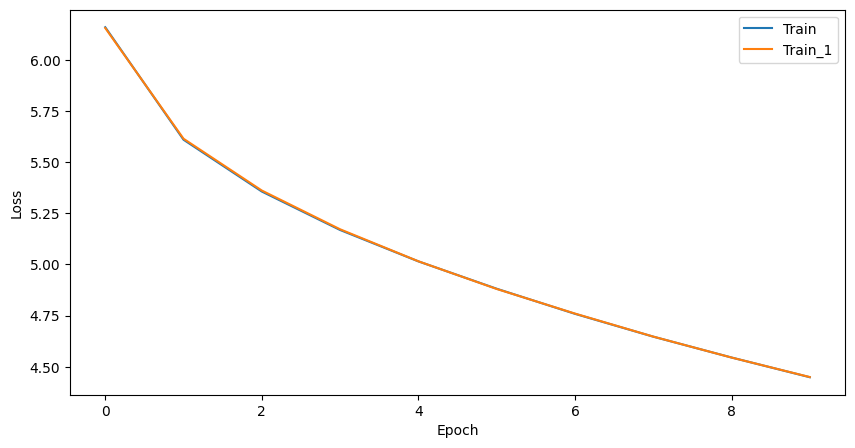

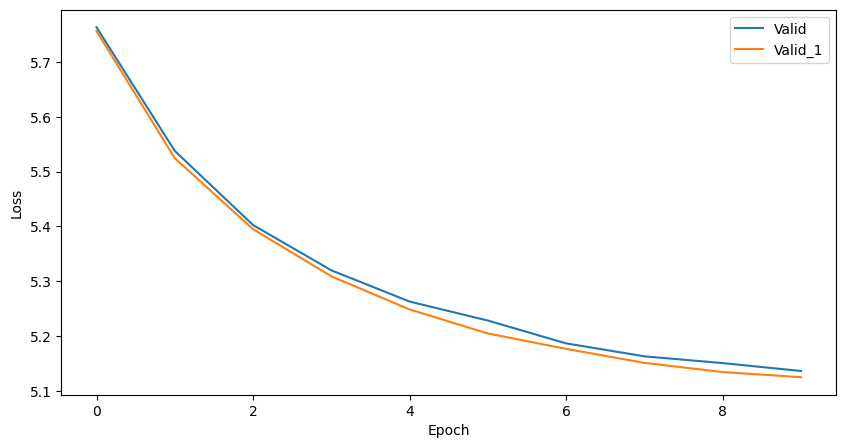

In [198]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses[:10], label='Train')
plt.plot(train_losses_1, label='Train_1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot perplexities
plt.figure(figsize=(10, 5))
plt.plot(valid_losses[:10], label='Valid')
plt.plot(valid_losses_1, label='Valid_1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [125]:
# lstm model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, inputs, hidden):
        embeds = self.embedding(inputs)
        output, hidden = self.lstm(embeds, hidden)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    


In [ ]:
# excise 3.2 TODO

In [126]:
# excise 3.3
learning_rate = 0.002
num_epochs = 10
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0

# Train model
model_3 = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
train_losses_3, valid_losses_3, train_perplexities_3, valid_perplexities_3 = train(model=model_3,
                                                                           model_type='LSTM',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device,
                                                                            clip=0.5
                                                                            )



Epoch [1/10], Step[0/1549], Loss: 9.2110, Perplexity: 10006.63
Epoch [1/10], Step[100/1549], Loss: 6.0214, Perplexity: 412.17
Epoch [1/10], Step[200/1549], Loss: 5.9543, Perplexity: 385.41
Epoch [1/10], Step[300/1549], Loss: 5.7591, Perplexity: 317.05
Epoch [1/10], Step[400/1549], Loss: 9.2747, Perplexity: 10664.71
Epoch [1/10], Step[500/1549], Loss: 5.0991, Perplexity: 163.87
Epoch [1/10], Step[600/1549], Loss: 5.1844, Perplexity: 178.47
Epoch [1/10], Step[700/1549], Loss: 5.3929, Perplexity: 219.85
Epoch [1/10], Step[800/1549], Loss: 5.1618, Perplexity: 174.48
Epoch [1/10], Step[900/1549], Loss: 5.1081, Perplexity: 165.36
Epoch [1/10], Step[1000/1549], Loss: 5.0748, Perplexity: 159.93
Epoch [1/10], Step[1100/1549], Loss: 5.3530, Perplexity: 211.24
Epoch [1/10], Step[1200/1549], Loss: 5.1369, Perplexity: 170.19
Epoch [1/10], Step[1300/1549], Loss: 5.0956, Perplexity: 163.30
Epoch [1/10], Step[1400/1549], Loss: 4.8188, Perplexity: 123.82
Epoch [1/10], Step[1500/1549], Loss: 5.1629, Per

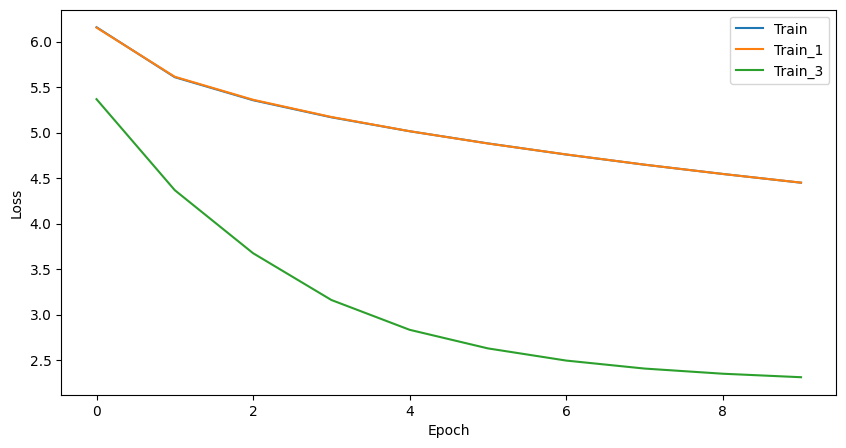

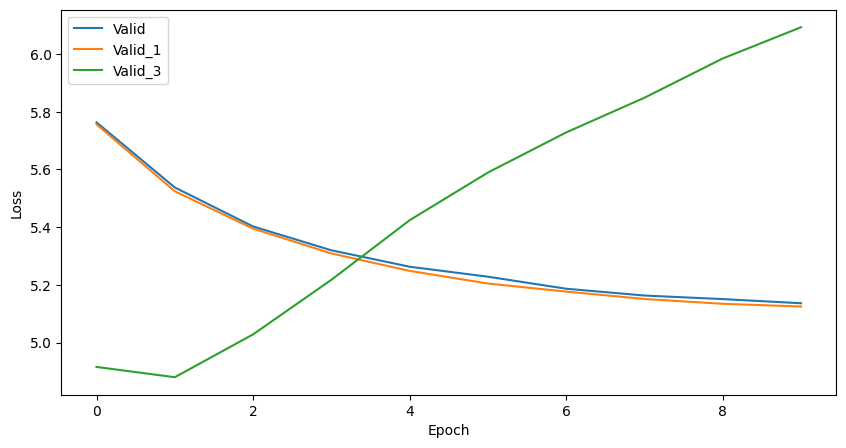

In [199]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses[:10], label='Train')
plt.plot(train_losses_1, label='Train_1')
plt.plot(train_losses_3, label='Train_3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot perplexities
plt.figure(figsize=(10, 5))
plt.plot(valid_losses[:10], label='Valid')
plt.plot(valid_losses_1, label='Valid_1')
plt.plot(valid_losses_3, label='Valid_3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [129]:
# Test
test_loss_3, test_perplexity_3 = evaluate(model_3, 'LSTM', test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_3), 'test_perplexity =', '{:.4f}'.format(test_perplexity_3))

# Generate
int_to_word = dict((v, k) for k, v in vocab.items())
generated_words = generate(model_3, 'LSTM', "sampling", vocab_size, int_to_word, seq_len, device)
print(generated_words)

# Save model
#torch.save(model.state_dict(), 'model.ckpt')

test_loss = 2.5193 test_perplexity = 12.4203
audio options steps to sears in further actions by news red brokerage against ual and fellow institutions 

of the attempting to leave the european community commission and regulatory reform area officials and other people can think the rules may be used to therapy setting new york the current continuing official raises regulators 

leaves from the california earthquake the rise in british opposition to west germany 's estate in the soviet markets by the massachusetts institute of canada as well as on the indian requirements of japan enough to offer <unk> <unk> for democracy 

as many as N


In [131]:
# excise 3.3 gated recurrent unit (GRU)

class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, inputs, hidden):
        embeds = self.embedding(inputs)
        output, hidden = self.gru(embeds, hidden)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

learning_rate = 0.002
num_epochs = 10
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0

# Train model
model_4 = GRU(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
train_losses_4, valid_losses_4, train_perplexities_4, valid_perplexities_4 = train(model=model_4,
                                                                           model_type='GRU',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device,
                                                                            clip=0.5
                                                                            )

Epoch [1/10], Step[0/1549], Loss: 9.2097, Perplexity: 9993.47
Epoch [1/10], Step[100/1549], Loss: 5.8925, Perplexity: 362.33
Epoch [1/10], Step[200/1549], Loss: 5.8543, Perplexity: 348.72
Epoch [1/10], Step[300/1549], Loss: 5.6475, Perplexity: 283.57
Epoch [1/10], Step[400/1549], Loss: 5.5409, Perplexity: 254.90
Epoch [1/10], Step[500/1549], Loss: 5.0382, Perplexity: 154.20
Epoch [1/10], Step[600/1549], Loss: 5.1385, Perplexity: 170.45
Epoch [1/10], Step[700/1549], Loss: 5.2236, Perplexity: 185.61
Epoch [1/10], Step[800/1549], Loss: 5.1650, Perplexity: 175.04
Epoch [1/10], Step[900/1549], Loss: 5.0308, Perplexity: 153.06
Epoch [1/10], Step[1000/1549], Loss: 5.0170, Perplexity: 150.96
Epoch [1/10], Step[1100/1549], Loss: 5.3335, Perplexity: 207.16
Epoch [1/10], Step[1200/1549], Loss: 5.1903, Perplexity: 179.52
Epoch [1/10], Step[1300/1549], Loss: 5.0636, Perplexity: 158.16
Epoch [1/10], Step[1400/1549], Loss: 4.8821, Perplexity: 131.91
Epoch [1/10], Step[1500/1549], Loss: 5.0794, Perple

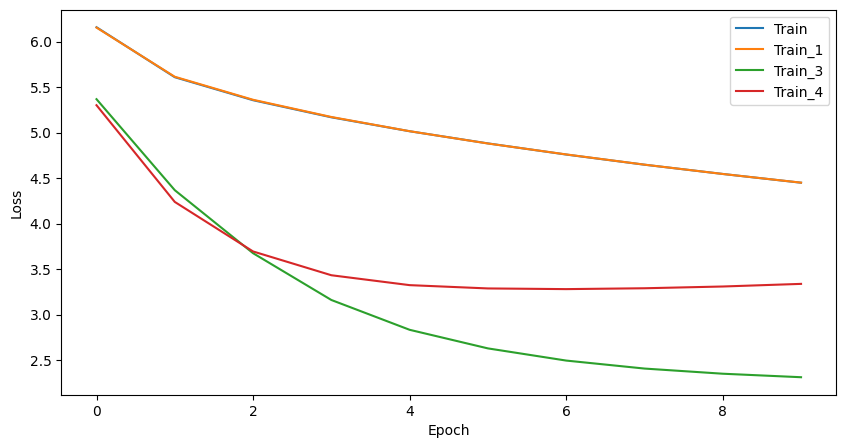

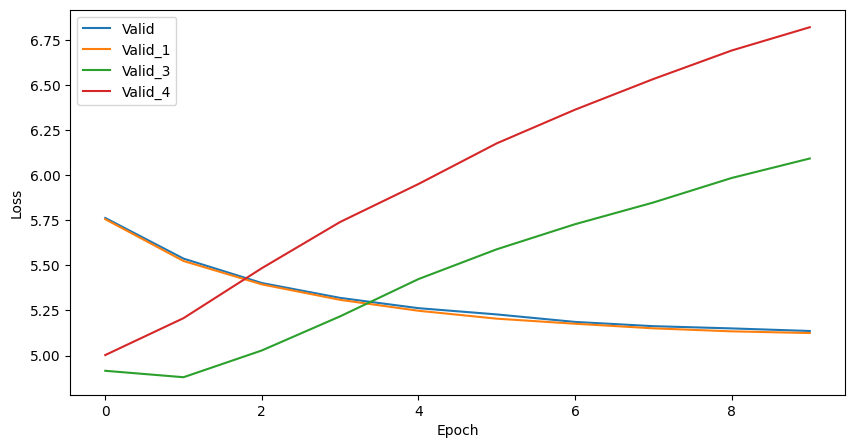

In [200]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses[:10], label='Train')
plt.plot(train_losses_1, label='Train_1')
plt.plot(train_losses_3, label='Train_3')
plt.plot(train_losses_4, label='Train_4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot perplexities
plt.figure(figsize=(10, 5))
plt.plot(valid_losses[:10], label='Valid')
plt.plot(valid_losses_1, label='Valid_1')
plt.plot(valid_losses_3, label='Valid_3')
plt.plot(valid_losses_4, label='Valid_4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [137]:
# Test
test_loss_4, test_perplexity_4 = evaluate(model_4, 'GRU', test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_4), 'test_perplexity =', '{:.4f}'.format(test_perplexity_4))

# Generate
int_to_word = dict((v, k) for k, v in vocab.items())
generated_words = generate(model_4, 'GRU', "sampling", vocab_size, int_to_word, seq_len, device)
print(generated_words)

# Save model
#torch.save(model.state_dict(), 'model.ckpt')

test_loss = 3.3573 test_perplexity = 28.7112
preference stands essential red lights favors reveals when inflation has fueled an alternative in august over the transportation department 

why economists the union leader <unk> <unk> now that you had a base of some other <unk> 

yet you certainly are asking some environmentalists donations most recommending to present whether for a <unk> news broadcast mr. engelken in <unk> <unk> and chicago even those who seek <unk> to say the united project 

i feel but we feel there are signs of the being waiting behind the season 's <unk> there are going to be said we totally a


In [141]:
# excise 3.4 bidirectional recurrent neural network (RNN)
class BIDI_RECTIONAL_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(BIDI_RECTIONAL_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(hidden_size*2, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, inputs, hidden):
        embeds = self.embedding(inputs)
        output, hidden = self.lstm(embeds, hidden)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers*2, batch_size, self.hidden_size),
                torch.zeros(self.num_layers*2, batch_size, self.hidden_size))

In [143]:
# excise 3.4 bidirectional recurrent neural network (RNN)
learning_rate = 0.002
num_epochs = 2
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0

# Train model
model_5 = BIDI_RECTIONAL_LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
train_losses_5, valid_losses_5, train_perplexities_5, valid_perplexities_5 = train(model=model_5,
                                                                           model_type='LSTM',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device,
                                                                            clip=0.5
                                                                            )

Epoch [1/2], Step[0/1549], Loss: 9.2108, Perplexity: 10004.92
Epoch [1/2], Step[100/1549], Loss: 2.7117, Perplexity: 15.05
Epoch [1/2], Step[200/1549], Loss: 1.6260, Perplexity:  5.08
Epoch [1/2], Step[300/1549], Loss: 0.9456, Perplexity:  2.57
Epoch [1/2], Step[400/1549], Loss: 0.7200, Perplexity:  2.05
Epoch [1/2], Step[500/1549], Loss: 0.5771, Perplexity:  1.78
Epoch [1/2], Step[600/1549], Loss: 0.5233, Perplexity:  1.69
Epoch [1/2], Step[700/1549], Loss: 0.6117, Perplexity:  1.84
Epoch [1/2], Step[800/1549], Loss: 0.5246, Perplexity:  1.69
Epoch [1/2], Step[900/1549], Loss: 0.4458, Perplexity:  1.56
Epoch [1/2], Step[1000/1549], Loss: 0.4644, Perplexity:  1.59
Epoch [1/2], Step[1100/1549], Loss: 0.5162, Perplexity:  1.68
Epoch [1/2], Step[1200/1549], Loss: 0.5208, Perplexity:  1.68
Epoch [1/2], Step[1300/1549], Loss: 0.4601, Perplexity:  1.58
Epoch [1/2], Step[1400/1549], Loss: 0.4108, Perplexity:  1.51
Epoch [1/2], Step[1500/1549], Loss: 0.4622, Perplexity:  1.59
Epoch: 0001 train

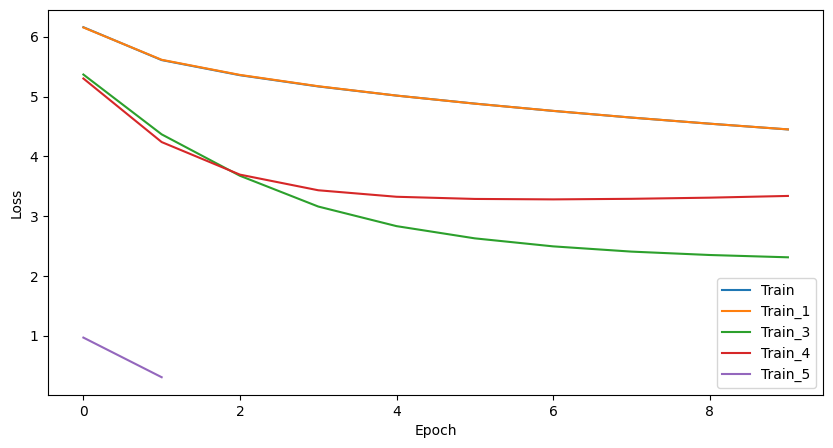

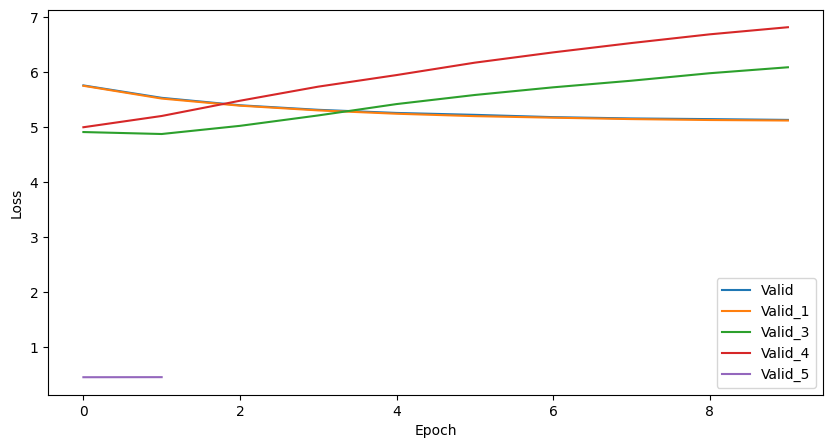

In [201]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses[:10], label='Train')
plt.plot(train_losses_1, label='Train_1')
plt.plot(train_losses_3, label='Train_3')
plt.plot(train_losses_4, label='Train_4')
plt.plot(train_losses_5, label='Train_5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot perplexities
plt.figure(figsize=(10, 5))
plt.plot(valid_losses[:10], label='Valid')
plt.plot(valid_losses_1, label='Valid_1')
plt.plot(valid_losses_3, label='Valid_3')
plt.plot(valid_losses_4, label='Valid_4')
plt.plot(valid_losses_5, label='Valid_5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [147]:
# Test
test_loss_5, test_perplexity_5 = evaluate(model_5, 'LSTM', test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_5), 'test_perplexity =', '{:.4f}'.format(test_perplexity_5))

# Generate
int_to_word = dict((v, k) for k, v in vocab.items())
generated_words = generate(model_5, 'LSTM', "sampling", vocab_size, int_to_word, seq_len, device)
print(generated_words)

# Save model
#torch.save(model.state_dict(), 'model.ckpt')

test_loss = 0.2618 test_perplexity = 1.2993
he could he could he could be could be free be free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free free


In [179]:
# excise 3.4 transformer neural network (optional)
class transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.transformer = nn.Transformer(d_model=embedding_dim, nhead=8, num_encoder_layers=6, num_decoder_layers=2, dim_feedforward=hidden_size, dropout=dropout)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, inputs, hidden):
        embeds = self.embedding(inputs)
        output = self.transformer(embeds, embeds)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [180]:
# excise 3.4 transformer neural network (optional)
learning_rate = 0.002
num_epochs = 10
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0

# Train model
model_6 = transformer(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
train_losses_6, valid_losses_6, train_perplexities_6, valid_perplexities_6 = train(model=model_6,
                                                                           model_type='LSTM',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device,
                                                                            clip=0.5
                                                                            )

Epoch [1/10], Step[0/1549], Loss: 9.2858, Perplexity: 10783.87
Epoch [1/10], Step[100/1549], Loss: 6.3836, Perplexity: 592.03
Epoch [1/10], Step[200/1549], Loss: 6.2955, Perplexity: 542.14
Epoch [1/10], Step[300/1549], Loss: 6.1103, Perplexity: 450.49
Epoch [1/10], Step[400/1549], Loss: 5.9944, Perplexity: 401.19
Epoch [1/10], Step[500/1549], Loss: 5.6306, Perplexity: 278.84
Epoch [1/10], Step[600/1549], Loss: 5.6010, Perplexity: 270.71
Epoch [1/10], Step[700/1549], Loss: 5.7882, Perplexity: 326.43
Epoch [1/10], Step[800/1549], Loss: 5.5175, Perplexity: 249.00
Epoch [1/10], Step[900/1549], Loss: 5.5560, Perplexity: 258.78
Epoch [1/10], Step[1000/1549], Loss: 5.5404, Perplexity: 254.77
Epoch [1/10], Step[1100/1549], Loss: 5.8125, Perplexity: 334.44
Epoch [1/10], Step[1200/1549], Loss: 5.6169, Perplexity: 275.04
Epoch [1/10], Step[1300/1549], Loss: 5.5874, Perplexity: 267.05
Epoch [1/10], Step[1400/1549], Loss: 5.4070, Perplexity: 222.97
Epoch [1/10], Step[1500/1549], Loss: 5.6851, Perpl

In [177]:
# Test
test_loss_6, test_perplexity_6 = evaluate(model_6, 'LSTM', test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_6), 'test_perplexity =', '{:.4f}'.format(test_perplexity_6))

# Generate
int_to_word = dict((v, k) for k, v in vocab.items())
generated_words = generate(model_6, 'LSTM', "sampling", vocab_size, int_to_word, seq_len, device)
print(generated_words)

# Save model
#torch.save(model.state_dict(), 'model.ckpt')

test_loss = 4.6631 test_perplexity = 105.9596
and the wars of about putting sci tv dial tone of the current N by an official at the continuing operations and N billion 

about psyllium boom and <unk> with nasd 's agreement also has a series senate but the maintain the securities however fears of your estimated at which firmed the two sides were doing really believe that must be made to less than earlier this year but institutional sellers said that <unk> tactical asset 's to assess the option expires 

tension for that it moves these shares outstanding 

just lost N 

the earnings and


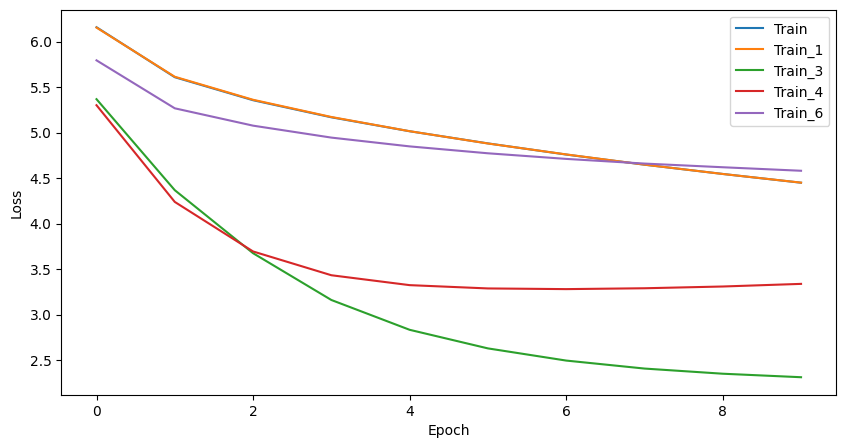

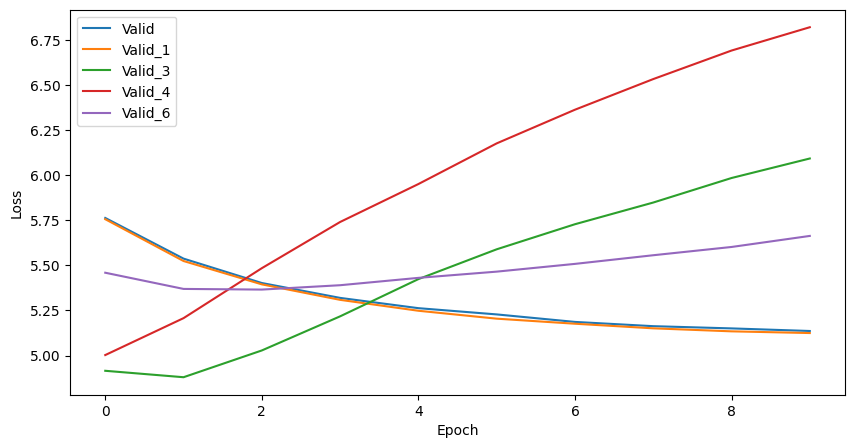

In [202]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses[:10], label='Train')
plt.plot(train_losses_1, label='Train_1')
plt.plot(train_losses_3, label='Train_3')
plt.plot(train_losses_4, label='Train_4')
plt.plot(train_losses_6, label='Train_6')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot perplexities
plt.figure(figsize=(10, 5))
plt.plot(valid_losses[:10], label='Valid')
plt.plot(valid_losses_1, label='Valid_1')
plt.plot(valid_losses_3, label='Valid_3')
plt.plot(valid_losses_4, label='Valid_4')
plt.plot(valid_losses_6, label='Valid_6')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# try to use bert to do the language model

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertForMaskedLM, BertTokenizer

# Define your custom language modeling dataset
class LanguageModelDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Tokenize the text
        tokens = self.tokenizer.encode(text, add_special_tokens=True)

        # Create input and target sequences
        input_seq = tokens[:-1]
        target_seq = tokens[1:]

        return torch.tensor(input_seq), torch.tensor(target_seq)

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
model = BertForMaskedLM.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Prepare your training data
train_texts = ['Example sentence 1', 'Example sentence 2', ...]
train_dataset = LanguageModelDataset(train_texts, tokenizer)

# Set up data loader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for input_seqs, target_seqs in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_seqs)

        # Compute loss
        loss = loss_fn(outputs.logits.view(-1, model.config.vocab_size), target_seqs.view(-1))
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}')

# Save the trained language model
model.save_pretrained('path_to_save_model')
tokenizer.save_pretrained('path_to_save_tokenizer')
